## Imports

In [0]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


Using TensorFlow backend.


## PriceHubble Dataset


In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
train_dir = '../gdrive/My Drive/classified/kit/train'
test_dir = '../gdrive/My Drive/classified/kit/test'

## Pre-Trained Model: InceptionV3


In [0]:
base_model = InceptionV3(include_top=False, weights='imagenet')

W0723 12:20:06.647291 139649140574080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 12:20:06.672915 139649140574080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 12:20:06.677126 139649140574080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 12:20:06.700149 139649140574080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0723 12:20:06.701200 1396491405

87916544/87910968 [==============================] - 3s 0us/step


##Input Pipeline

In [0]:
datagen_train = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5, 1.5],
    rescale=1./255)

datagen_test = ImageDataGenerator(
    rescale=1./255)

In [0]:
input_shape = (299, 299, 3)
batch_size_train = 32
batch_size_test = 16

In [0]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape[:2],
                                                    batch_size=batch_size_train,
                                                    shuffle=True,
                                                    class_mode='binary')

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape[:2],
                                                  batch_size=batch_size_test,
                                                  shuffle=False,
                                                  class_mode='binary')

Found 896 images belonging to 2 classes.
Found 224 images belonging to 2 classes.


## Transfer Learning

In [0]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='relu')(x) 
# and a logistic layer
predictions = Dense(1, activation='sigmoid')(x)

# model
model = Model(inputs=base_model.input, outputs=predictions)


In [0]:
# structure of the model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
def print_layer_trainable():
    for layer in model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [0]:
print_layer_trainable()

True:	input_1
True:	conv2d
True:	batch_normalization
True:	activation
True:	conv2d_1
True:	batch_normalization_1
True:	activation_1
True:	conv2d_2
True:	batch_normalization_2
True:	activation_2
True:	max_pooling2d
True:	conv2d_3
True:	batch_normalization_3
True:	activation_3
True:	conv2d_4
True:	batch_normalization_4
True:	activation_4
True:	max_pooling2d_1
True:	conv2d_8
True:	batch_normalization_8
True:	activation_8
True:	conv2d_6
True:	conv2d_9
True:	batch_normalization_6
True:	batch_normalization_9
True:	activation_6
True:	activation_9
True:	average_pooling2d
True:	conv2d_5
True:	conv2d_7
True:	conv2d_10
True:	conv2d_11
True:	batch_normalization_5
True:	batch_normalization_7
True:	batch_normalization_10
True:	batch_normalization_11
True:	activation_5
True:	activation_7
True:	activation_10
True:	activation_11
True:	mixed0
True:	conv2d_15
True:	batch_normalization_15
True:	activation_15
True:	conv2d_13
True:	conv2d_16
True:	batch_normalization_13
True:	batch_normalization_16
True:	ac

In [0]:
loss = 'binary_crossentropy'
optimizer = Adam(lr=1e-4)
metrics = ['accuracy']

In [0]:
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

W0723 12:22:04.933404 139649140574080 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 12:22:04.952749 139649140574080 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
epochs = 5
steps_per_epoch = generator_train.n / batch_size_train
steps_test = generator_test.n / batch_size_test
steps_per_epoch

28.0

In [0]:
reduceLROnPlateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=0.000001,
    verbose=1,
    mode='min')

earlyStopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='min')


In [0]:
history = model.fit_generator(generator=generator_train,
                              validation_data=generator_test,
                              epochs=epochs,
                              steps_per_epoch=steps_per_epoch,
                              validation_steps=steps_test,
                              callbacks=[reduceLROnPlateau, earlyStopping])


Epoch 1/5
28/28 [==============================] - 1067s 38s/step - loss: 0.3502 - acc: 0.8616 - val_loss: 0.1515 - val_acc: 0.9375
Epoch 2/5
28/28 [==============================] - 1041s 37s/step - loss: 0.0917 - acc: 0.9676 - val_loss: 0.0934 - val_acc: 0.9688
Epoch 3/5
28/28 [==============================] - 1038s 37s/step - loss: 0.0431 - acc: 0.9821 - val_loss: 0.1043 - val_acc: 0.9688
Epoch 4/5
28/28 [==============================] - 1038s 37s/step - loss: 0.0581 - acc: 0.9777 - val_loss: 0.1575 - val_acc: 0.9509
Epoch 5/5
28/28 [==============================] - 1039s 37s/step - loss: 0.0446 - acc: 0.9844 - val_loss: 0.1221 - val_acc: 0.9688


In [0]:
result = model.evaluate_generator(generator_test, steps=steps_test)


In [0]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))


Test-set classification accuracy: 96.88%


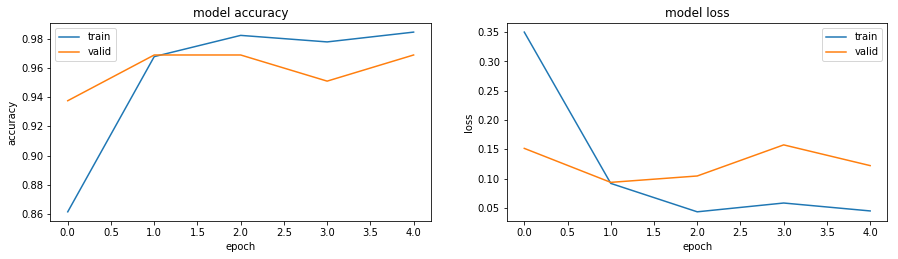

In [0]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()
